$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\var}{var}
    \DeclareMathOperator{\cov}{cov}
    \newcommand{\bnaive}{\widehat{\beta}}
    \newcommand{\bbayes}{\widetilde{\beta}}
    \newcommand{\bboot}{\beta^{*}}
    \newcommand{\bdouble}{\beta^{**}}
    \newcommand{\bbootnv}{\hat{\beta}^*}
    \newcommand{\bbootby}{\widetilde{\beta}^*}
    \newcommand{\bcorrect}{\beta^{\checkmark}}
    \newcommand{\bbayescorrect}{\widetilde{\beta}^{\checkmark}}
    \newcommand{\ybar}{\bar{Y}}
    \newcommand{\ypred}{\widetilde{y}}
    \newcommand{\ybarpred}{\widetilde{\bar{Y}}}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \newcommand{\thresh}{\ybar{}_0}
    \newcommand{\muo}{\mu_{0}}
    \newcommand{\sigo}{\sigma_{0}}
    \newcommand{\hmt}{\bar{Y_t}}
    \newcommand{\hst}{s_t^2}
    \newcommand{\hmc}{\bar{Y_c}}
    \newcommand{\hsc}{s_c^2}
    \newcommand{\mt}{\mu_t}
    \newcommand{\sigt}{\sigma_t}
    \newcommand{\vt}{\sigma_t^2}
    \newcommand{\mc}{\mu_c}
    \newcommand{\vc}{\sigma_c^2}
    \newcommand{\sigc}{\sigma_c}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \newcommand{\below}{\unicode{x25E7}}
    \newcommand{\above}{\unicode{x25E8}}
    \newcommand{\discont}{\unicode{x25EB}}
    \newcommand{\jbelow}{\unicode{x21E5}}
    \newcommand{\jabove}{\unicode{x21E4}}
$$

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# The Idea

We've noticed a few properties of our standard GP model with SE kernel:
1. Regression to the mean
2. Continuity of the derivatives across the boundary

In this notebook, I want to address the second property. We've seen that in some of the examples we've looked at, that's not a desirable property of the model. In particular, the artificial "Lee" example used in RDD literature has a very different polynomial on either side of the boundary.

So I wanted to explore modification of the SE kernel to address this, in order to introduce a kink in the GP. Hence the catchy name “kinky GP.” The idea is to:
1. take two separate GPs, on either side of the threshold (at which the discontinuity occurs)
2. introduce points right at the discontinuity, on either side
3. condition on the GPs being equal at each point. 

I'll explain this in more details.

# One Dimension

In [1]:
import PyPlot
plt=PyPlot
plt.svg(true)
using LaTeXStrings
using GaussianProcesses
using Distributions
import PyPlot; plt=PyPlot
;

We start by setting up the squared exponential kernel. We compute the covariance matrix as if we had a single GP.

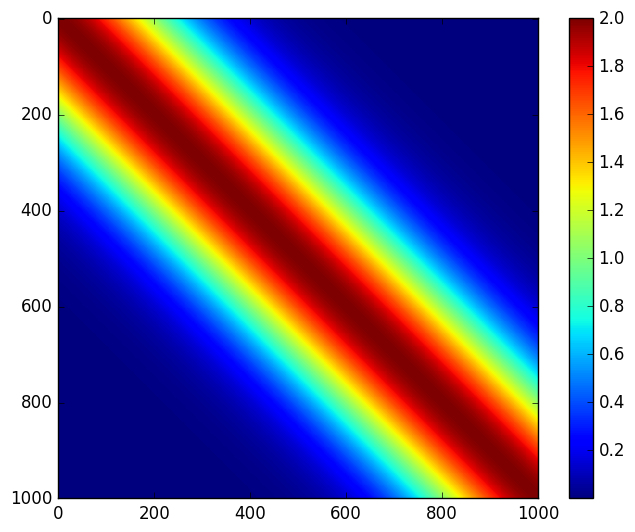

In [2]:
thresh = 0.0

# data-generating parameters
σf2_star = 2.0
Lstar  = 1.05
τstar = 0.75
σy2_star = 0.1

kern = SE(log(Lstar), log(√σf2_star))
nx1 = 1000
X1 = linspace(-3,3,nx1)
K = GaussianProcesses.crossKern(X1', kern)

plt.imshow(K, interpolation="nearest")
plt.colorbar()
;

We then zero out the covariance between the two sides, to create two separate GPs.

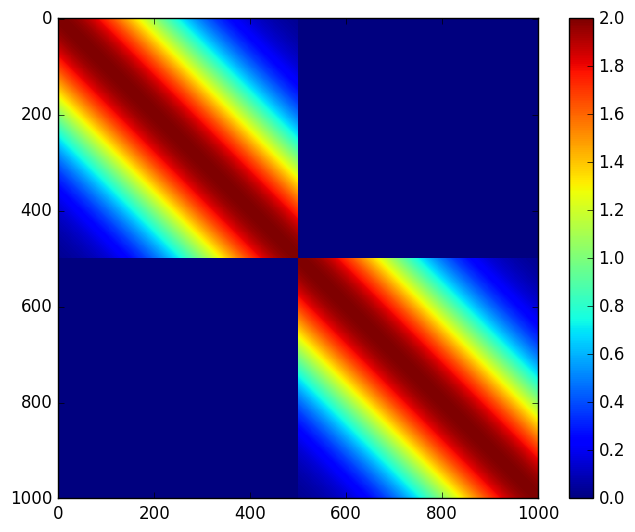

In [3]:
◧ = X1 .< thresh
◨ = !◧
n◧ = sum(◧)
K[◧,◨] = 0.0
K[◨,◧] = 0.0
plt.imshow(K, interpolation="nearest")
plt.colorbar()
;

Now we introduce the points at the boundary, and compute the covariance with the other points on their respective sides:

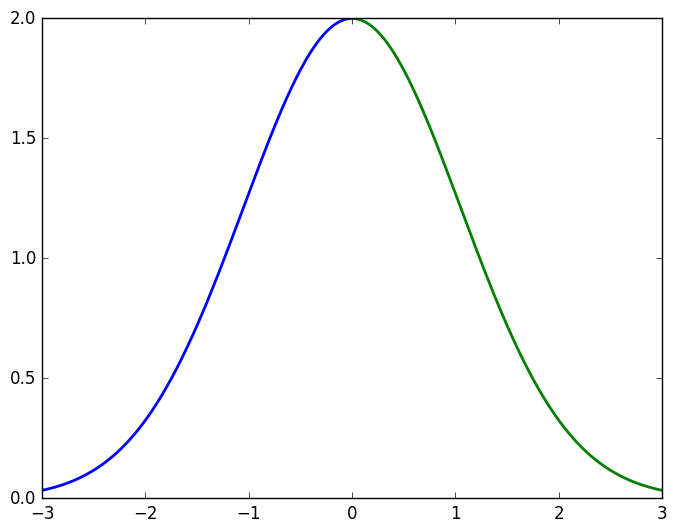

In [4]:
# spatial positions
X◧ = X1[◧]
X◨ = X1[◨]
X◫ = [0.0]

# K: separated kernel
K◧◧ = K[◧,◧]
K◨◨ = K[◨,◨]
K◫◫ = GaussianProcesses.crossKern(X◫', kern)
#     plt.imshow(K◫◫)
K◧◫ = GaussianProcesses.crossKern(X◧', X◫', kern)
K◨◫ = GaussianProcesses.crossKern(X◨', X◫', kern)
plt.plot(X◧, K◧◫, linewidth=2)
plt.plot(X◨, K◨◫, linewidth=2)
;

Now comes a bit of MVN theory. We start with the two separate GPs:

$$ \begin{pmatrix}
        Y_\below \\
        Y_\above
    \end{pmatrix} \sim \normal\del{
    \begin{pmatrix}0\\0\end{pmatrix}, 
    \begin{bmatrix}
        K_{\below\below} & 0 \\ 0 & K_{\above\above}
    \end{bmatrix}
    }
$$

We introduce the two points $Y_\jbelow$ (just below the discontinuity) and $Y_\jabove$ (just above) at the boundary position $X_\discont$. In the 2D case, $X_\discont$ is actually multiple points along the threshold, and so we will look at the general case here. The squared exponential kernel gives us the covariance between $Y_\below$ and $Y_\jbelow$, and between $Y_\above$ and $Y_\jabove$, denoted $K_{\below\jbelow}$ and $K_{\above\jabove}$. The SE kernel is also applicable between points along the boundary, and so we obtain $K_{\jbelow\jbelow}$ and $K_{\jabove\jabove}$ (which are equal matrices).

$$ \begin{pmatrix}
        Y_\below \\
        Y_\jbelow \\
        Y_\jabove \\
        Y_\above
    \end{pmatrix} \sim \normal\del{
    \begin{pmatrix}0\\0\\0\\0\end{pmatrix}, 
    \begin{bmatrix}
        K_{\below\below} & K_{\below\jbelow} & 0 & 0 \\ 
        K_{\jbelow\below} & K_{\jbelow\jbelow} & 0 & 0 \\
        0 & 0 & K_{\jabove\jabove} & K_{\jabove\above} \\
        0 & 0 & K_{\above\jabove} & K_{\above\above}
    \end{bmatrix}
    }
$$

Now we subtract $Y_\jabove$ from $Y_\jbelow$:
$$ \begin{pmatrix}
        Y_\below \\
        Y_\jbelow - Y_\jabove \\
        Y_\above
    \end{pmatrix} \sim \normal\del{
    \begin{pmatrix}0\\0\\0\end{pmatrix}, 
    \begin{bmatrix}
        K_{\below\below} & K_{\below\jbelow}  & 0 \\ 
        K_{\jbelow\below} & \del{K_{\jbelow\jbelow}+K_{\jabove\jabove}} & K_{\jabove\above} \\
        0 & K_{\above\jabove} & K_{\above\above}
    \end{bmatrix}
    }
$$
And now, condition on $Y_\jbelow - Y_\jabove = 0$:
$$ \left. \begin{pmatrix}
        Y_\below \\
        Y_\above
    \end{pmatrix} \mid Y_\jbelow - Y_\jabove = 0 \right. \sim \normal\del{
    \begin{pmatrix}0\\0\end{pmatrix}, 
    \begin{bmatrix}
        K_{\below\below} & 0 \\ 0 & K_{\above\above}
    \end{bmatrix} -
    \underbrace{
    \begin{bmatrix}
        K_{\below\jbelow} \\ K_{\above\jabove}
    \end{bmatrix}
    \begin{bmatrix}
        K_{\jbelow\jbelow}+K_{\jabove\jabove}
    \end{bmatrix}^{-1}
        \begin{bmatrix}
        K_{\jbelow\below} & K_{\jabove\above}
    \end{bmatrix}}_{L}
    }
$$

Let's go ahead and implement just that:

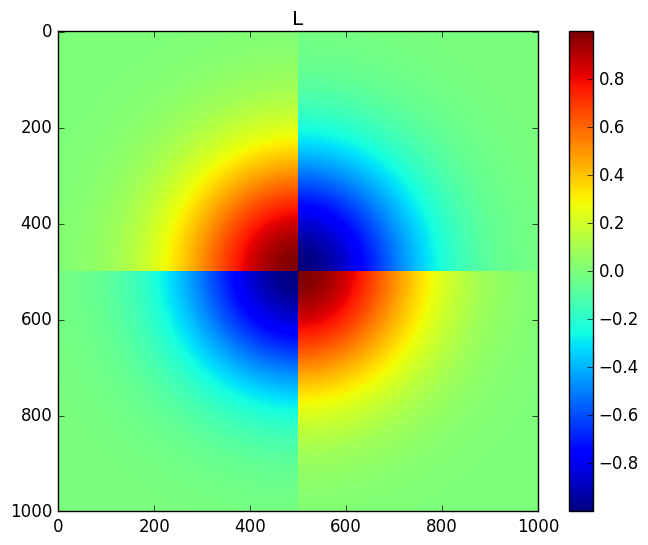

In [5]:
# L: variance removed by conditioning on continuity at boundary
L = [K◧◫ ; -K◨◫] / (2*K◫◫) * [K◧◫ ; -K◨◫]'
plt.imshow(L, interpolation="nearest")
plt.colorbar()
plt.title("L")
;

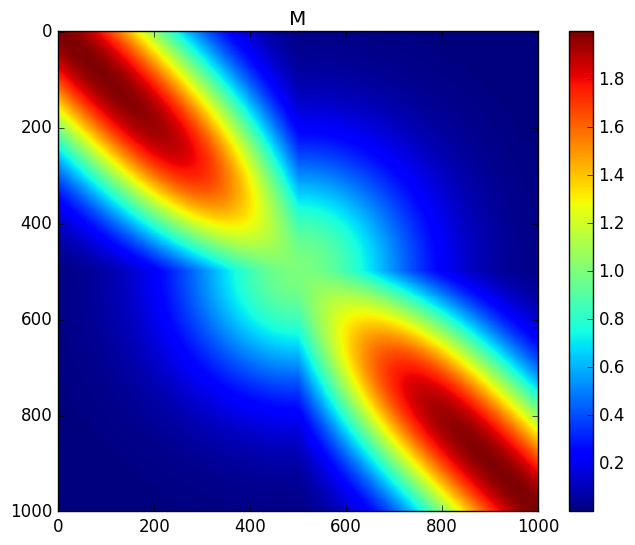

In [6]:
# M: mixed kernel
M = similar(K)
M[◧,◧] = K◧◧ - L[1:n◧,1:n◧]
M[◨,◨] = K◨◨ - L[n◧+1:end,n◧+1:end]
M[◧,◨] = -L[1:n◧,n◧+1:end]
M[◨,◧] = -L[n◧+1:end,1:n◧]
plt.imshow(M, interpolation="nearest")
plt.colorbar()
plt.title("M")
;

## Simulations

In [7]:
module ⬠
    using Distributions
    using GaussianProcesses
    function separate(K::AbstractMatrix, X::AbstractVector, thresh::Real)
        sides = X .> thresh
        Ksep = copy(K)
        Ksep[sides,!sides] = 0.0
        Ksep[!sides,sides] = 0.0
        return Ksep
    end


    function kink(K::AbstractMatrix, X::AbstractVector, thresh::Real, kern::Kernel)
        # legend:
        # ◧ points to the left of the boundary
        # ◨ points to the right of the boundary
        # ◫ points at the boundary

        ◧ = X .< thresh
        ◨ = !◧
        n◧ = sum(◧)

        n◫ = 10
        # spatial positions
        X◧ = X[◧]
        X◨ = X[◨]
        X◫ = [thresh]

        # K: separated kernel
        K◧◧ = K[◧,◧]
        K◨◨ = K[◨,◨]
        K◫◫ = GaussianProcesses.crossKern(X◫', kern)
        K◧◫ = GaussianProcesses.crossKern(X◧', X◫', kern)
        K◨◫ = GaussianProcesses.crossKern(X◨', X◫', kern)

        # L: variance removed by conditioning on continuity at boundary
        L = [K◧◫ ; -K◨◫] / (2*K◫◫) * [K◧◫ ; -K◨◫]'

        # M: mixed kernel
        M = similar(K)
        M[◧,◧] = K◧◧ - L[1:n◧,1:n◧]
        M[◨,◨] = K◨◨ - L[n◧+1:end,n◧+1:end]
        M[◧,◨] = -L[1:n◧,n◧+1:end]
        M[◨,◧] = -L[n◧+1:end,1:n◧]    
        return M#(M+M')/2
    end
    function simulate_separateGP{T<:Number,S<:Number,Ker<:Kernel}(τ::T, kern::Ker, 
            thresh::Real, X::AbstractVector{S})
        n = size(X,1)
        K = GaussianProcesses.crossKern(X', kern)
        Kmod = separate(K, X, thresh)
        fXdistr = MvNormal(zeros(n), Kmod+ 1e-10*eye(n))
        fX = rand(fXdistr)
        return fX
    end

    function simulate_kinkyGP{T<:Number,S<:Number,Ker<:Kernel}(τ::T, kern::Ker, 
            thresh::Real, X::AbstractVector{S})
        n = size(X,1)
        K = GaussianProcesses.crossKern(X', kern)
        Kmod = ⬠.kink(K, X, thresh, kern)
        fXdistr = MvNormal(zeros(n), Kmod+ 1e-10*eye(n))
        fX = rand(fXdistr)
        return fX
    end
end

στ2 = 100.0 # diffuse normal prior on τ
kern = SE(log(Lstar), log(√σf2_star))


sepfGP = ⬠.simulate_separateGP(τstar, kern, thresh, X1)
kinkfGP = ⬠.simulate_kinkyGP(τstar, kern, thresh, X1)
fTreated = copy(kinkfGP)
fTreated[X1.>thresh] += τstar
;

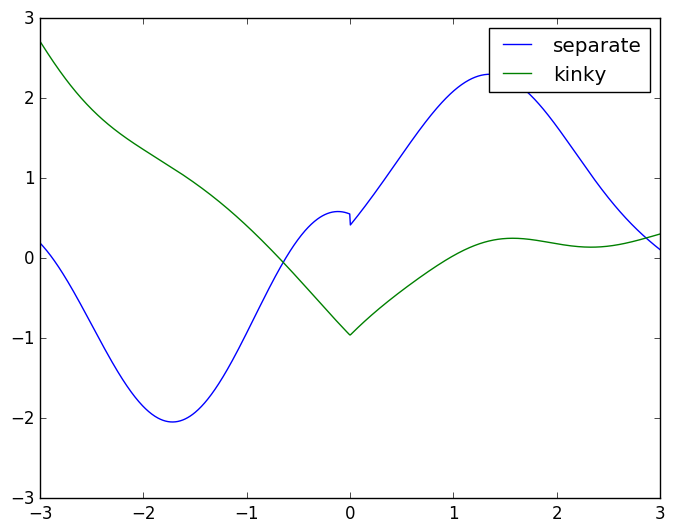

In [8]:
plt.plot(X1, sepfGP, label="separate")
plt.plot(X1, kinkfGP, label="kinky")
plt.legend();

# Two dimensions

Same thing in 2D.

In [9]:
module ⬠2
    using Distributions
    using GaussianProcesses
    import PDMats
    
    abstract Kmodifier
    type Separate <: Kmodifier
        thresh::Float64
    end
    type Kinky <: Kmodifier
        thresh::Float64
        kern::GaussianProcesses.Kernel
    end
    type Identity <: Kmodifier
    end
    
    function modif!(km::Identity, K::AbstractMatrix, Xrow::AbstractMatrix, Xcol::AbstractMatrix)
        return K
    end
    
    function modif!(km::Separate, K::AbstractMatrix, Xrow::AbstractMatrix, Xcol::AbstractMatrix)
        ◧row = Xrow[:,1] .< km.thresh
        ◨row = !◧row
        ◧col = Xcol[:,1] .< km.thresh
        ◨col = !◧col
        
        K[◧row,◨col] = 0.0
        K[◨row,◧col] = 0.0
        return K
    end

    function modif!(K::AbstractMatrix, X::AbstractMatrix, thresh::Real, kern::Kernel)
        # legend:
        # ◧ points to the left of the boundary
        # ◨ points to the right of the boundary
        # ◫ points at the boundary

        ◧ = X[:,1] .< thresh
        ◨ = !◧
        n◧ = sum(◧)

        n◫ = 10
        # spatial positions
        X◧ = X[◧,:]
        X◨ = X[◨,:]
        X2◫ = linspace(minimum(X[:,2])-1, maximum(X[:,2])+1, n◫)
        X1◫ = ones(Float64, n◫) * thresh # all points on the boundary
        X◫ = [X1◫ X2◫]

        # K: separated kernel
        K◧◧ = K[◧,◧]
        K◨◨ = K[◨,◨]
        K◫◫ = GaussianProcesses.crossKern(X◫', kern)
        K◧◫ = GaussianProcesses.crossKern(X◧', X◫', kern)
        K◨◫ = GaussianProcesses.crossKern(X◨', X◫', kern)

        # L: variance removed by conditioning on continuity at boundary
        L = [K◧◫ ; -K◨◫] / (2*K◫◫) * [K◧◫ ; -K◨◫]'

        # modify kernel
        K[◧,◧] = K◧◧ - L[1:n◧,1:n◧]
        K[◨,◨] = K◨◨ - L[n◧+1:end,n◧+1:end]
        K[◧,◨] = -L[1:n◧,n◧+1:end]
        K[◨,◧] = -L[n◧+1:end,1:n◧]
        return K
    end
    function modif!(km::Kinky, K::AbstractMatrix, Xrow::AbstractMatrix, Xcol::AbstractMatrix)
        # legend:
        # ◧ points to the left of the boundary
        # ◨ points to the right of the boundary
        # ◫ points at the boundary

        ◧row = Xrow[:,1] .< km.thresh
        ◨row = !◧row
        n◧row = sum(◧row)

        ◧col = Xcol[:,1] .< km.thresh
        ◨col = !◧col
        n◧col = sum(◧col)

        n◫ = 10
        # spatial positions
        X◧row = Xrow[◧row,:]
        X◨row = Xrow[◨row,:]
        X◧col = Xcol[◧col,:]
        X◨col = Xcol[◨col,:]
        X2◫ = linspace(minimum(Xrow[:,2])-1, maximum(Xrow[:,2])+1, n◫)
        X1◫ = ones(Float64, n◫) * km.thresh # all points on the boundary
        X◫ = [X1◫ X2◫]

        # K: separated kernel
        K◧◧ = K[◧row,◧col]
        K◨◨ = K[◨row,◨col]
        K◫◫ = GaussianProcesses.crossKern(X◫', km.kern)
        K◧◫ = GaussianProcesses.crossKern(X◧row', X◫', km.kern)
        K◨◫ = GaussianProcesses.crossKern(X◨row', X◫', km.kern)
        K◫◧ = GaussianProcesses.crossKern(X◫', X◧col', km.kern)
        K◫◨ = GaussianProcesses.crossKern(X◫', X◨col', km.kern)

        # L: variance removed by conditioning on continuity at boundary
        L = [K◧◫ ; -K◨◫] / (2*K◫◫) * [K◫◧ -K◫◨]

        # modify kernel
        K[◧row,◧col] = K◧◧ - L[1:n◧row,1:n◧col]
        K[◨row,◨col] = K◨◨ - L[n◧row+1:end,n◧col+1:end]
        K[◧row,◨col] = -L[1:n◧row,n◧col+1:end]
        K[◨row,◧col] = -L[n◧row+1:end,1:n◧col]
        return K
    end

    function simulate_GP{S<:Number,Ker<:Kernel}(kern::Ker, km::Kmodifier, X::AbstractMatrix{S})
        n = size(X,1)
        K = GaussianProcesses.crossKern(X', kern)
        Kmod = modif!(km, K, X, X)
        fXdistr = MvNormal(zeros(n), Kmod+ 1e-10*eye(n))
        fX = rand(fXdistr)
        return fX
    end
    function simulate_2GP{S<:Number,Ker<:Kernel}(kern::Ker, thresh::Real, X::AbstractMatrix{S})
        km = Separate(thresh)
        return simulate_GP(kern, km, X)
    end
    function simulate_1GP{S<:Number,Ker<:Kernel}(kern::Ker, thresh::Real, X::AbstractMatrix{S})
        km = Identity()
        return simulate_GP(kern, km, X)
    end
    function simulate_kinkyGP{S<:Number,Ker<:Kernel}(kern::Ker, thresh::Real, X::AbstractMatrix{S})
        km = Kinky(thresh, kern)
        return simulate_GP(kern, km, X)
    end
    
    ## Inference
    type CovarianceComponents{T<:Real}
        Σf::AbstractArray{T}
        Στ::AbstractArray{T}
        Σβ::AbstractArray{T}
        Σy::AbstractArray{T}
    end
    function g_VarY(cc::CovarianceComponents)
        cc.Σf + cc.Στ + cc.Σβ + cc.Σy
    end 

    function g_CC{T<:Number, S<:Number}(Xrow::Array{T}, Xcol::Array{T}, km::Kmodifier,
            thresh::T, στ2::T, σβ2::T, σy2::S, kern::SEIso)
        ◧row = Xrow[:,1] .< thresh
        ◨row = !◧row
        ◧col = Xcol[:,1] .< thresh
        ◨col = !◧col
        II = ◨row * ◨col'
        K = GaussianProcesses.crossKern(Xrow', Xcol', kern)
        Kmod = modif!(km, K, Xrow, Xcol)
        n = size(Xcol,1)
        In=eye(n)
        XXt = Xrow * Xcol'
        return CovarianceComponents(Kmod, στ2*II, σβ2*XXt, σy2*In)
    end

    function τ_posterior{T<:Real, S<:Number}(X::Array{Float64}, Y::Vector{Float64}, km::Kmodifier, 
            στ2::T, σβ2::T, σy2::S, kern::SEIso, thresh::Float64)
        cc = g_CC(X, X, km, thresh, στ2, σβ2, σy2, kern)
        VarY = PDMats.PDMat(g_VarY(cc))
        ◨ = (X[:,1] .> thresh)*1.0
        alpha = VarY \ Y
        Eτ_Y =(στ2 * ◨' * alpha)[1]
        Lck = PDMats.whiten(VarY, ◨'')
        Vτ_Y = (στ2 - στ2^2 .* Lck' * Lck)[1]
        τ_Y = Normal(Eτ_Y, √(Vτ_Y))
        return τ_Y
    end

#     function fτ_posterior{T<:Real, S<:Number}(X::Array{Float64}, Y::Vector{Float64}, στ2::T, σβ2::T, σy2::S, σf2::S, L::S, thresh::Float64)
#         XXt = Symmetric(X * X')
#         cc = g_CC(X, XXt, thresh, στ2, σβ2, σy2, σf2, L)
#         VarY = PDMats.PDMat(g_VarY(cc))
#         alpha = VarY \ Y
#         Σfτ = cc.Σf + cc.Στ
#         Lck = PDMats.whiten(VarY, Σfτ)
#         μpost = (Σfτ * alpha)
#         Σpost = Σfτ - Lck'Lck
#     #     fτ_post = MvNormal(μpost, Σpost)
#         return μpost, Σpost
#     end
    function fτ_predict{T<:Real, S<:Number}(Xpred::Array{Float64}, Xobs::Array{Float64}, Y::Vector{Float64}, 
            km::Kmodifier, 
            στ2::T, σβ2::T, σy2::S, kern::SEIso, thresh::Float64)
        XXt = Symmetric(Xobs * Xobs')
        cc_obs = g_CC(Xobs, Xobs, km, thresh, στ2, σβ2, σy2, kern)

        VarY = PDMats.PDMat(g_VarY(cc_obs))
        alpha = VarY \ Y
        
        cc_pred = g_CC(Xpred, Xpred, km, thresh, στ2, σβ2, σy2, kern)
        Σfτ_pred = cc_pred.Σf + cc_pred.Στ
        
        cc_cross = g_CC(Xpred, Xobs, km, thresh, στ2, σβ2, σy2, kern)
        Σfτ_cross = cc_cross.Σf + cc_cross.Στ
        Lck = PDMats.whiten(VarY, Σfτ_cross')
        μpost = (Σfτ_cross * alpha)
        Σpost = Σfτ_pred - Lck'Lck
        return μpost, Σpost
    end
end

⬠2

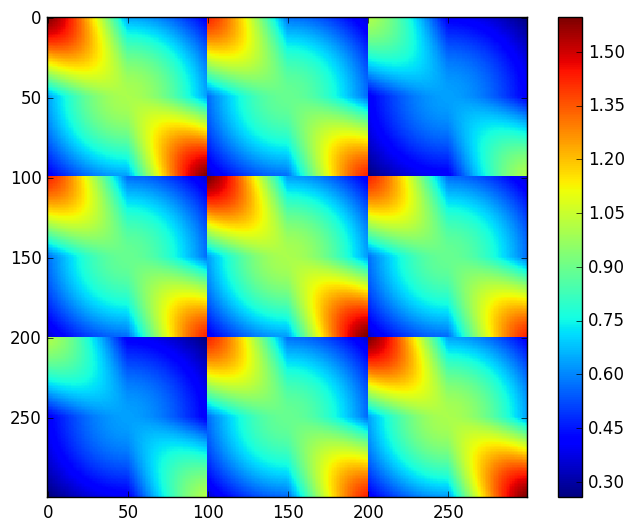

In [22]:
nx2=3
nx1 = 100
X1 = linspace(-1,1,nx1)
X2 = linspace(0, 1, nx2)
X = zeros(Float64, (nx1*nx2,2))
for (i,x1x2) in enumerate(vec([(x1,x2) for x1 in X1, x2 in X2]))
    X[i,1] = x1x2[1]
    X[i,2] = x1x2[2]
end

kinkGP2 = ⬠2.simulate_kinkyGP(kern, thresh, X)
sepfGP2 = ⬠2.simulate_2GP(kern, thresh, X)
K = GaussianProcesses.crossKern(X', kern)
kinky = ⬠2.Kinky(thresh, kern)
Kkink = ⬠2.modif!(kinky, K, X, X)
plt.clf()
plt.imshow(Kkink, interpolation="nearest")
plt.colorbar()
;

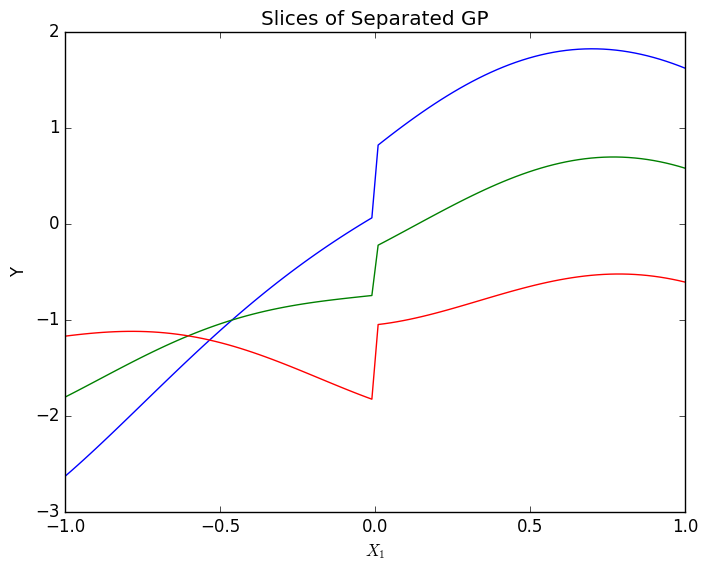

In [23]:
for j in 1:nx2
    plt.plot(X[1:nx1,1], sepfGP2[(j-1)*nx1+1:j*nx1])
end
plt.title("Slices of Separated GP")
plt.xlabel(L"X_1")
plt.ylabel("Y")
;

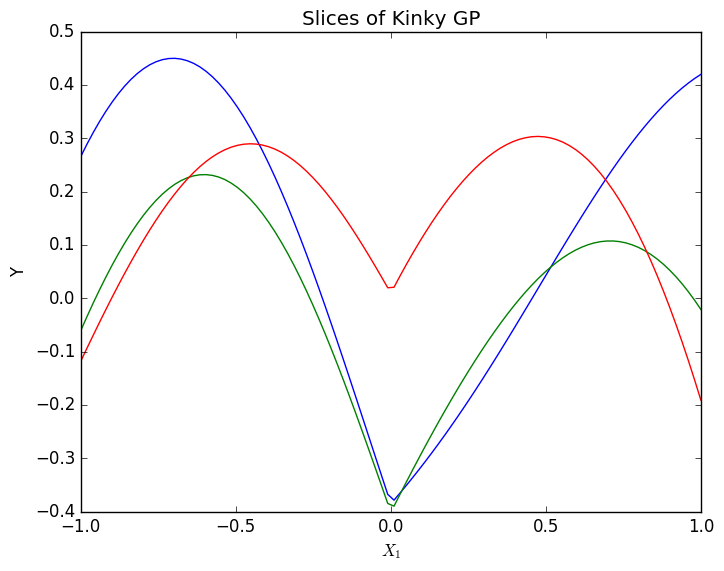

In [24]:
for j in 1:nx2
    plt.plot(X[1:nx1,1], kinkGP2[(j-1)*nx1+1:j*nx1])
end
plt.title("Slices of Kinky GP")
plt.xlabel(L"X_1")
plt.ylabel("Y")
;

Add treatment effect and observation noise.

In [25]:
noise = rand(Normal(0,√σy2_star), nx1*nx2)
fTreated = copy(kinkGP2)
fTreated[X[:,1].>thresh] += τstar
Y = fTreated .+ noise
;

# Inference on $\tau$

In [26]:
τpost = ⬠2.τ_posterior(X, Y, kinky,
        0.5, 0.0, σy2_star, kern, thresh)

Distributions.Normal(μ=0.6666235887202239, σ=0.10460544215862703)

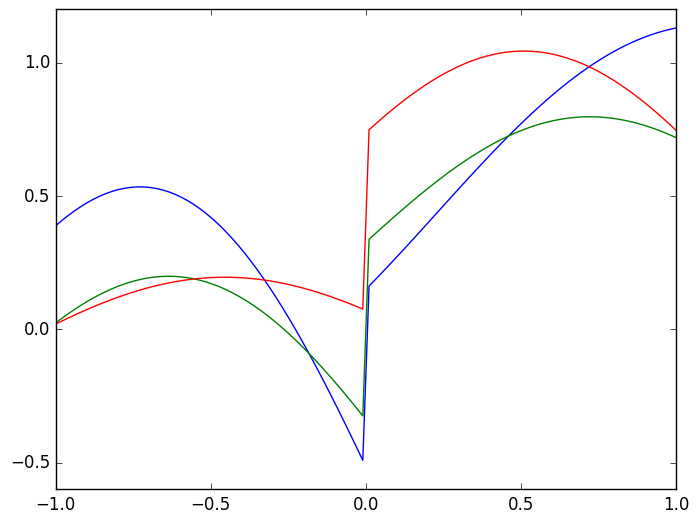

In [27]:
fτpost = ⬠2.fτ_predict(X, X, Y, kinky,
        0.5, 0.0, σy2_star, kern, thresh)
for j in 1:nx2
    plt.plot(X[1:nx1,1], fτpost[1][(j-1)*nx1+1:j*nx1])
end      

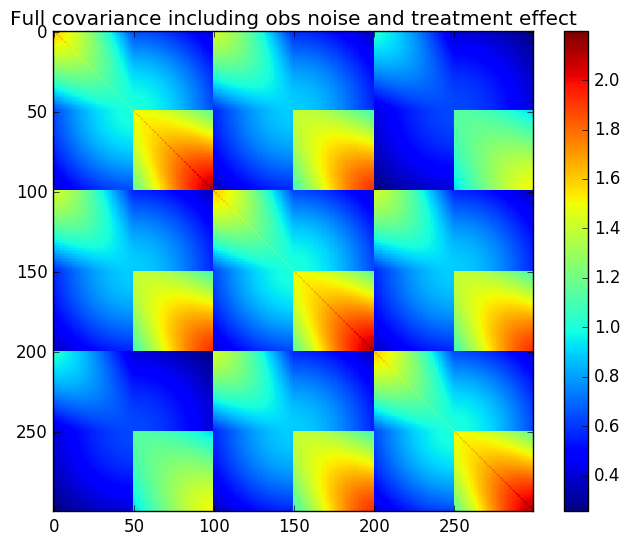

In [29]:
VarY = ⬠2.g_VarY(⬠2.g_CC(X, X, kinky, thresh, 0.5, 0.0, σy2_star, kern))
plt.clf()
plt.imshow(VarY, interpolation="nearest")
plt.title("Full covariance including obs noise and treatment effect")
plt.colorbar()
;

# Comparing Kinky GP to 1GP and 2GP

I'll simulate some data using the kinky GP simulator above, and fit a model using either the kinky GP, 1GP, or 2GP formulation. This will allow us to see how the three formulations differ in practice.

## in 1D

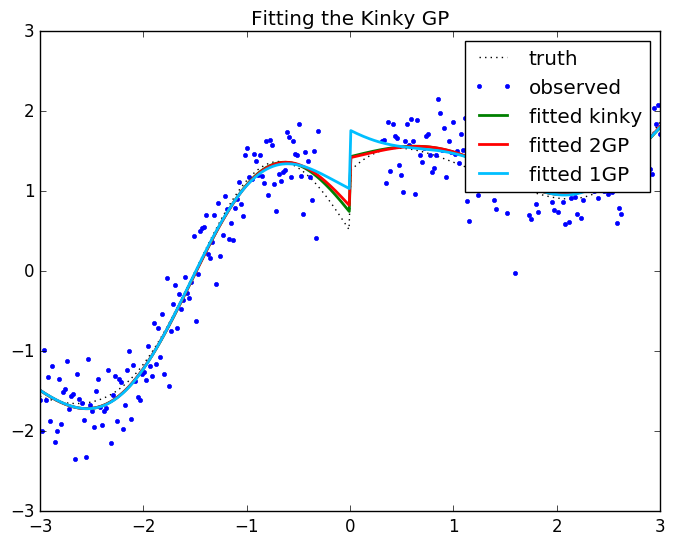

In [40]:
nx1 = 300
nx2 = 1
X1 = linspace(-3,3,nx1)
X2 = [0.0]
X = zeros(Float64, (nx1*nx2,2))
for (i,x1x2) in enumerate(vec([(x1,x2) for x1 in X1, x2 in X2]))
    X[i,1] = x1x2[1]
    X[i,2] = x1x2[2]
end
nx1_pred = 400
X1_pred = linspace(-3,3,nx1_pred)
X_pred = zeros(Float64, (nx1_pred*nx2,2))
for (i,x1x2) in enumerate(vec([(x1,x2) for x1 in X1_pred, x2 in X2]))
    X_pred[i,1] = x1x2[1]
    X_pred[i,2] = x1x2[2]
end

kinkGP2 = ⬠2.simulate_kinkyGP(kern, thresh, X)
noise = rand(Normal(0,√σy2_star), nx1*nx2)
fTreated = copy(kinkGP2)
fTreated[X[:,1].>thresh] += τstar
Y = fTreated .+ noise
observed = abs(X[:,1]).>0.3

plt.plot(X1, fTreated, label="truth", color="black", linestyle=":")
plt.plot(X1[observed], Y[observed], ".", label="observed")
for (kmod, s, col) in [
    (⬠2.Kinky(thresh, kern), "kinky", "green"),
    (⬠2.Separate(thresh), "2GP", "red"),
    (⬠2.Identity(), "1GP", "deepskyblue")]

    fτpred = ⬠2.fτ_predict(X_pred, X[observed,:], Y[observed], kmod,
            10.0, 0.0, σy2_star, kern, thresh)

    plt.plot(X_pred[:,1], fτpred[1], linewidth=2, label="fitted "s, color=col)
end
plt.legend()
plt.title("Fitting the Kinky GP")
;

We see that in 1D, the kinky GP and 2GP formulations behave very similarly. This is what Luke B had anticipated, although I still don't think that they are mathematically strictly the same. Meanwhile, the 1GP formulation is constrained to match the derivative on both sides of the discontinuity. If the assumption of continuous derivative is wrong, this causes the 1GP process to bend away from the truth significantly.

## in 2D

The code is exactly the same, but the visualization is a bit more challenging.

In [53]:
nx1 = 200
nx2 = 5
X1 = linspace(-3,3,nx1)
X2 = linspace(0,2,nx2)
X = zeros(Float64, (nx1*nx2,2))
for (i,x1x2) in enumerate(vec([(x1,x2) for x1 in X1, x2 in X2]))
    X[i,1] = x1x2[1]
    X[i,2] = x1x2[2]
end

X1_pred = [linspace(-2,-0.01,10) ; linspace(0.01, 2, 10)]
nx1_pred = length(X1_pred)
X_pred = zeros(Float64, (nx1_pred*nx2,2))
for (i,x1x2) in enumerate(vec([(x1,x2) for x1 in X1_pred, x2 in X2]))
    X_pred[i,1] = x1x2[1]
    X_pred[i,2] = x1x2[2]
end

X1_cliff = [-0.01, 0.01]
nx1_cliff = length(X1_cliff)
nx2_cliff = 100
X2_cliff = linspace(minimum(X2), maximum(X2), nx2_cliff)
X_cliff = zeros(Float64, (nx1_cliff*nx2_cliff,2))
for (i,x1x2) in enumerate(vec([(x1,x2) for x1 in X1_cliff, x2 in X2_cliff]))
    X_cliff[i,1] = x1x2[1]
    X_cliff[i,2] = x1x2[2]
end


kinkGP2 = ⬠2.simulate_kinkyGP(kern, thresh, [X; X_cliff])
noise = rand(Normal(0,√σy2_star), nx1*nx2)
fTreated = copy(kinkGP2)
fTreated[[X; X_cliff][:,1].>thresh] += τstar
fObser = fTreated[1:nx1*nx2]
fCliff = fTreated[nx1*nx2+1:end]
Y = fTreated[1:(nx1*nx2)] .+ noise
observed = abs(X[:,1]).>0.2
X1observed = abs(X1).>0.2
nx1_obs = sum(X1observed)

X1gridpred = X1_pred .+ 0X2'
X2gridpred = 0X1_pred .+ X2'
;

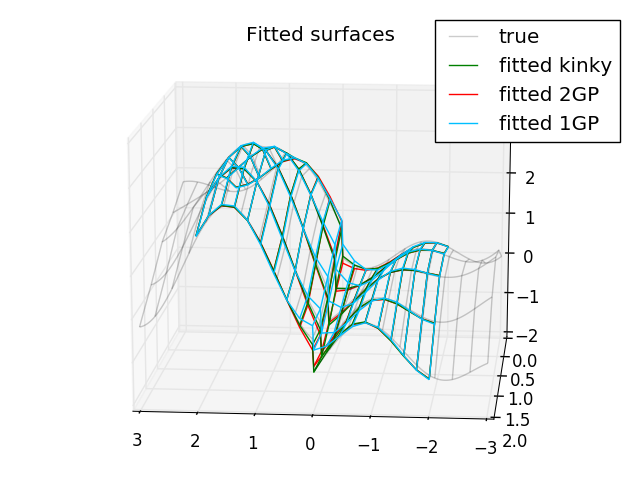

In [54]:
plt.plot_wireframe(X1 .+ 0X2', 0X1 .+ X2', reshape(fObser, (nx1,nx2)), rstride=10, color="black", label="true", alpha=0.2)
# plt.scatter3D(vec(X[observed,1]), vec(X[observed,2]), zs=vec(Y[observed]), c="red", )
ax=plt.gca()
ax[:view_init](elev=15, azim=95)
for (kmod, s, col) in [
    (⬠2.Kinky(thresh, kern), "kinky", "green"),
    (⬠2.Separate(thresh), "2GP", "red"),
    (⬠2.Identity(), "1GP", "deepskyblue")]

    fτpred = ⬠2.fτ_predict(X_pred, X[observed,:], Y[observed], kmod,
            10.0, 0.0, σy2_star, kern, thresh)
    plt.plot_wireframe(X1gridpred, X2gridpred, reshape(fτpred[1], (nx1_pred,nx2)), label="fitted "s, color=col)
end
plt.legend()
plt.title("Fitted surfaces")
;

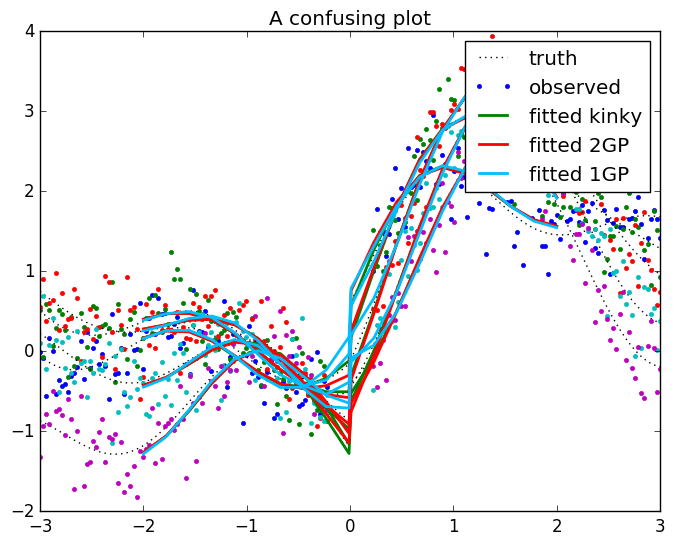

In [55]:
for j in 1:nx2
    label = j==1 ? "truth" : ""
    plt.plot(X1, fTreated[(j-1)*nx1+1:j*nx1], label=label, color="black", linestyle=":")
    Yslice = Y[(j-1)*nx1+1:j*nx1]
    label = j==1 ? "observed" : ""
    plt.plot(X1[X1observed], Yslice[X1observed], ".", label=label)
end
for (kmod, s, col) in [
    (⬠2.Kinky(thresh, kern), "kinky", "green"),
    (⬠2.Separate(thresh), "2GP", "red"),
    (⬠2.Identity(), "1GP", "deepskyblue")]

    fτpred = ⬠2.fτ_predict(X_pred, X[observed,:], Y[observed], kmod,
            10.0, 0.0, σy2_star, kern, thresh)
    for j in 1:nx2
        label = j==1 ? "fitted "s : ""
        plt.plot(X1_pred, fτpred[1][(j-1)*nx1_pred+1:j*nx1_pred], linewidth=2, label=label, color=col)
    end
end
plt.legend()
plt.title("A confusing plot")
;

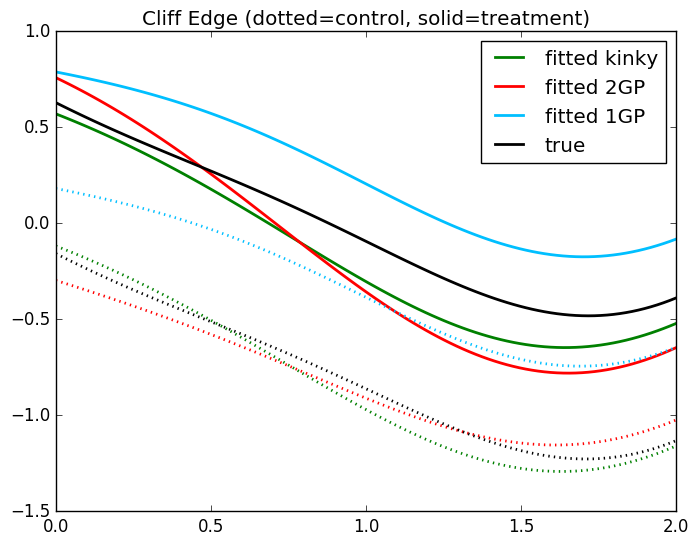

In [56]:
for (kmod, s, col) in [
    (⬠2.Kinky(thresh, kern), "kinky", "green"),
    (⬠2.Separate(thresh), "2GP", "red"),
    (⬠2.Identity(), "1GP", "deepskyblue")]

    fτpred = ⬠2.fτ_predict(X_cliff, X[observed,:], Y[observed], kmod,
            10.0, 0.0, σy2_star, kern, thresh)
    plt.plot(X2_cliff, fτpred[1][X_cliff[:,1].<thresh], linewidth=2,  linestyle=":", color=col)
    plt.plot(X2_cliff, fτpred[1][X_cliff[:,1].>thresh], linewidth=2, label="fitted "s, color=col)
end
plt.plot(X2_cliff, fCliff[X_cliff[:,1].<thresh], linewidth=2, linestyle=":", color="black")
plt.plot(X2_cliff, fCliff[X_cliff[:,1].>thresh], linewidth=2, label="true", color="black")
plt.legend()
plt.title("Cliff Edge (dotted=control, solid=treatment)")
;

We can see in this plot how the Kinky GP and the 1GP formulation have an embedded assumption of constant treatment effect all along the boundary, while the 2GP formulation allows the effect to narrow and widen along the boundary. Of course here I'm simulating from a kinky GP, so the kinky GP does well. This is not meant to be indicative of it being a better model.

In summary, the three formulations correspond to:
1. 1GP: constant treatment effect, continuous derivatives
2. Kinky GP: constant treatment effect, discontinuous derivatives
3. 2GP: variable treatment effect, discontinuous derivatives

Which to use is a modeling/scientific decision.